<div style="text-align: center;">
    <a href="https://www.dataia.eu/">
        <img border="0" src="https://github.com/ramp-kits/map_estimation/raw/main/img/DATAIA-h.png" width="45%"></a>
    <a href="https://www.hi-paris.fr/">
        <img border="0" src="https://www.hi-paris.fr/wp-content/uploads/2020/09/logo-hi-paris-retina.png" width="45%"></a>
</div>

# Non-invasive estimation of the MAP using PPG

<i> Thomas Moreau (Inria), François Caud (DATAIA - Université Paris-Saclay) </i>


<div style="text-align: center;">
<img src="https://github.com/ramp-kits/map_estimation/raw/main/img/GA_monitor_1.png" width=600px alt="Monitor in a operating room"></img>
</div>


## Introduction

The continuous monitoring of blood pressure is a major challenge in the general anesthesia field. Indeed, the monitoring of blood pressure is essential to ensure that the patient is stable during the operation. However, the current methods to measure blood pressure are either non-invasive, but non-continuous, or invasive, which can lead to complications, and expensive, making them inadapted in many situations.


<div style="text-align: center;">
<img src="https://github.com/ramp-kits/map_estimation/raw/main/img/cuff.avif" width=350px alt="Cuff for blood pressure measurment"></img>
</div>

A potential solution to this problem is to use non-invasive monitoring signals which are routinely collected, like the electrocardiogram (ECG)  photoplethysmogram (PPG) signal, to estimate the mean arterial pressure (MAP) using AI. The PPG signal is a non-invasive signal that can be easily acquired using a pulse oximeter. The MAP is a measure of the average blood pressure in an individual's arteries during one cardiac cycle.

<div style="text-align: center;">
<img src="https://github.com/ramp-kits/map_estimation/raw/main/img/ecg.avif" height=250px alt="ECG sensors"></img>
<img src="https://github.com/ramp-kits/map_estimation/raw/main/img/ppg.png" height=250px alt="PPG sensor"></img>
</div>

The goal of this challenge is to estimate the MAP from the non-invasive signals. The dataset consists of window of 10 seconds of PPG and ECG signals, with the related patient information (age, gender, weight, height, etc.) and the MAP measured with an invasive method.

A particular aspect of this challenge is the fact that we would like to have a
method that can generalize well to new patients in other hospitals. This is a
major issue in the medical field, where the data distribution can change and
it is very costly to collect new data.

For this reason, the challenge is a domain adaptation challenge. For training,
you have access to a dataset composed of data from 2 different domains:

- The "source" domain `'v'`, which corresponds to data collected in a first hospital.
  For this data, you have access to all the data and the labels (i.e. the MAP).
- The "target" domain `'m'`, composed of data collected in a second hospital.
  For this data, you have access to the data, but not the labels. In order to make it possible to test that everything is working properly, we give you the labels for 100 segments of the target domain in the test set.

The goal is therefore to generalize from the source domain to the target domain.

#### Extra resources

For this challenge, you can take a look at the following resources:

- [`skada`](https://scikit-adaptation.github.io/): a library for domain adaptation (DA) with a scikit-learn and PyTorch/skorch compatible API. This library implement many existing DA methods and can be used to implement your own methods.

# Exploratory data analysis

This notebook provides a simple exploratory data analysis of the dataset.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


### Load the data

The data is composed of 10 seconds windows of PPG and ECG signals, and the goal is to predict the MAP from these signals.

For this challenge, the data is large (>20Gb) so it cannot be loaded directly
when not enough RAM is available.
In this case, the data can be loaded in chunks (using `start/stop` arguments of `get_train_data`) or without all the high frequency waveforms (`load_waveform=False`).

In this notebook, we first load all the data without the waveforms to
illustrate the data distribution.

In [2]:
import problem

X_df, y = problem.get_train_data(load_waveform=False)

  
Let's first look at the data available.

In [3]:
print(f"There are {X_df.shape[0]} segment in this dataset.")
X_df.head()

There are 300750 segment in this dataset.


,n_seg,subject,age,gender,domain,height,weight,bmi,id,chunk
0,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
1,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
2,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
3,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
4,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN


The data has two types of features:
- Some patient information like the subject identifier, the age, the gender and the number of segment for this patient.
- The PPG and ECG signals in the segment.

We first start by looking at the statistics of the data:

There are 1203 unique subjects in the train set.


<Axes: title={'center': 'Number of segments per domain'}, xlabel='domain'>

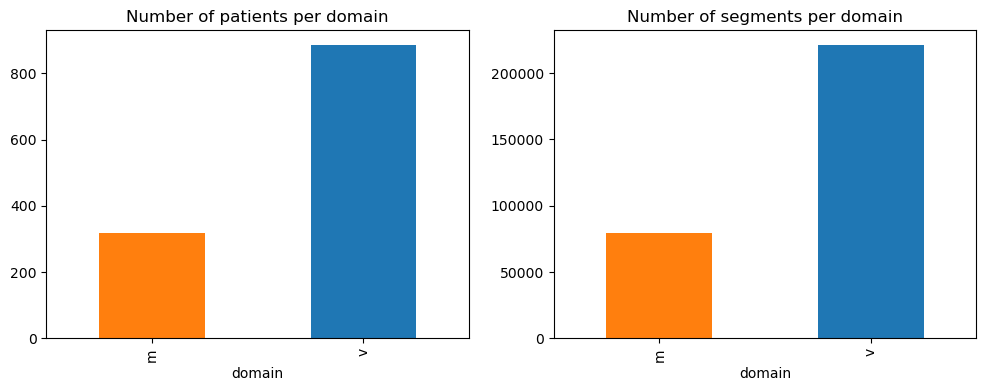

In [4]:
print(
    f"There are {X_df['subject'].nunique()} unique subjects in the train set."
)
# Display the number of subject/segments for each domain
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
X_df.groupby("domain")["subject"].apply(lambda x: x.nunique()).plot.bar(
    ax=axes[0], color=["C1", "C0"], title="Number of patients per domain"
)
X_df.groupby("domain").size().plot.bar(
    ax=axes[1], color=["C1", "C0"], title="Number of segments per domain"
)


We now look at the demographic information of the patients:

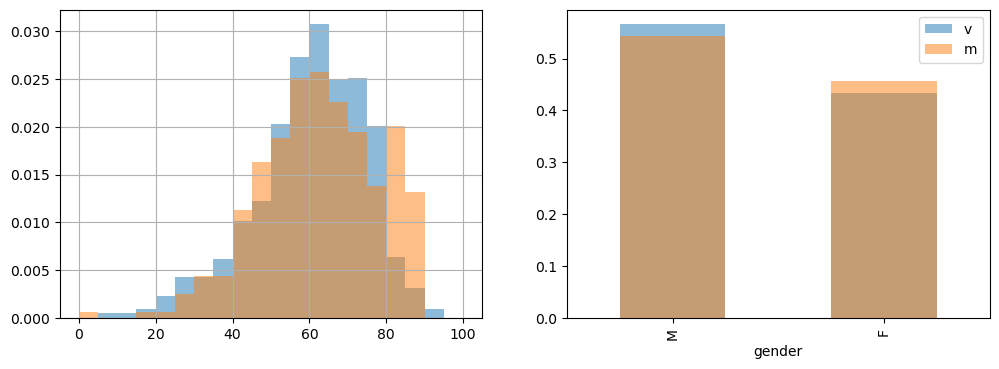

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
bins = np.linspace(0, 100, 21)
for i, domain in enumerate(["v", "m"]):
    X_ = X_df.query("domain == @domain")
    X_["age"].hist(
        ax=axes[0],
        bins=bins,
        density=True,
        alpha=0.5,
        label=domain,
        color=f"C{i}",
    )
    (X_["gender"].value_counts() / len(X_)).plot(
        kind="bar", ax=axes[1], label=domain, alpha=0.5, color=f"C{i}"
    )
plt.legend()


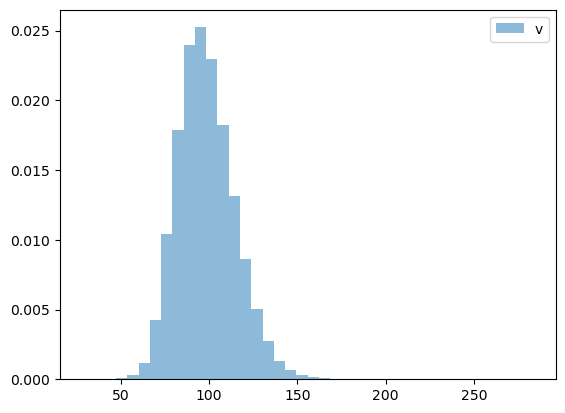

In [6]:
# Now let's check the distribution of the target
plt.hist(y[y != -1], bins=40, density=True, alpha=0.5, label="v")
plt.legend()

We see here that the distribution is skewed. Indeed, the international guidelines for anesthesiologist recommend a MAP between 70 and 105 mmHg, and to avoid having hypotension during the procedure.
As this data is observational, we see that we have very few data points with a MAP below 70 mmHg, which might be a problem for the model to learn the distribution of the MAP.


Now, we turn to the high-frequency signals contained in the data.
To avoid loading the entire dataset, we will load only the first 1000 rows of
the dataset.

In [7]:
import os

os.environ["RAMP_TEST_MODE"] = "1"

X_v, y = problem.get_train_data(start=0, stop=100)
X_m, y_m = problem.get_train_data(start=-101, stop=-1)
X_df = pd.concat([X_v, X_m], axis=0)
y = np.concatenate([y, y_m])

X_df

,n_seg,subject,age,gender,domain,height,weight,bmi,id,ecg,ppg,chunk
0,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",NaN
1,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",NaN
2,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",NaN
3,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",NaN
4,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2785793562708102, 0.28412874583795783, 0.25...","[0.19241192411924118, 0.1603432700993677, 0.13...",val
2096,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2987085906793936, 0.3161145423919146, 0.212...","[0.11162361623616242, 0.11531365313653143, 0.1...",val
2097,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.20290697674418606, 0.1430232558139535, 0.10...","[0.04311482622085346, 0.04311482622085346, 0.0...",val
2098,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.19429778247096094, 0.18373812038014786, 0.1...","[0.20263870094722602, 0.18775372124492556, 0.1...",val


The waveforms are stored as specific columns containing numpy arrays.  
They contain:
- **ECG:** the electrocardiogram signal, which is a measure of the electrical activity of the heart.
- **PPG:** the photoplethysmogram signal, which is a measure of the blood volume changes in the arteries.

We can plot them to see what they look like, and display the MAP value for each segment.  
Note that in this context, we do not have access to the MAP value for the target domain `m`.

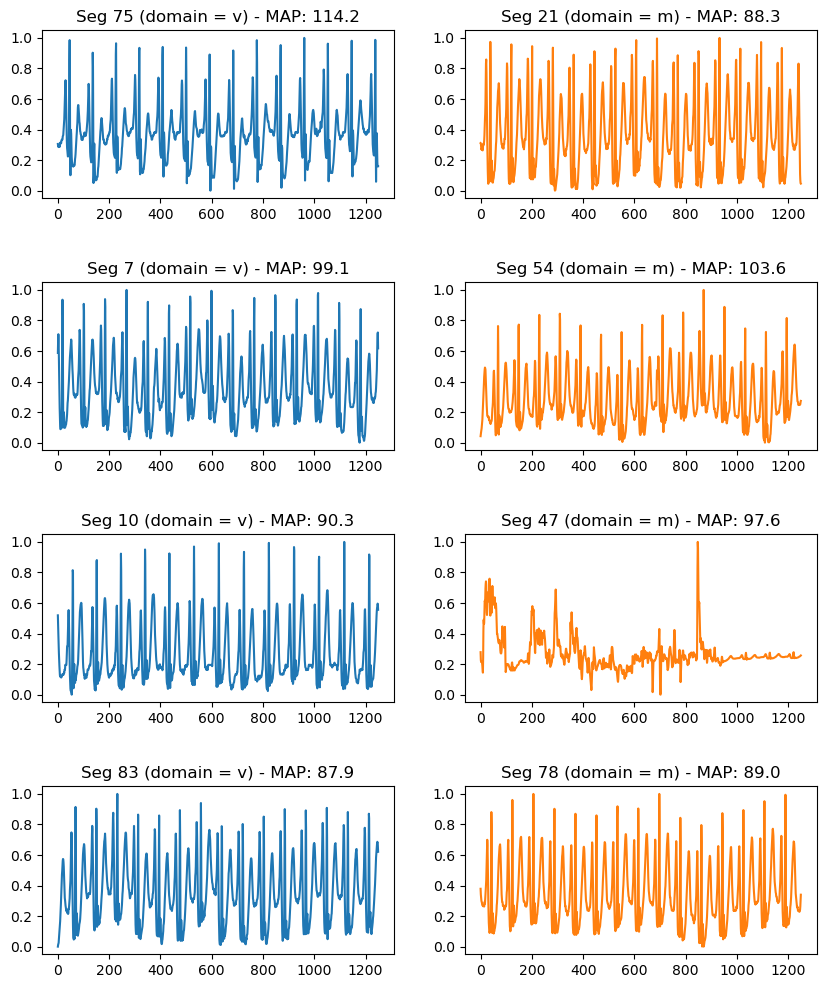

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.random.choice(min(100, len(X_m), len(X_v)), size=8, replace=False)
for i, ax in enumerate(axes.ravel()):
    d = "v" if i % 2 == 0 else "m"
    X_, y_ = (X_v, y) if i % 2 == 0 else (X_m, y_m)

    ax.plot(X_.iloc[idx[i]]["ecg"], c=f"C{i % 2}")
    ax.set_title(f"Seg {idx[i]} (domain = {d}) - MAP: {y_[idx[i]]:.1f}")

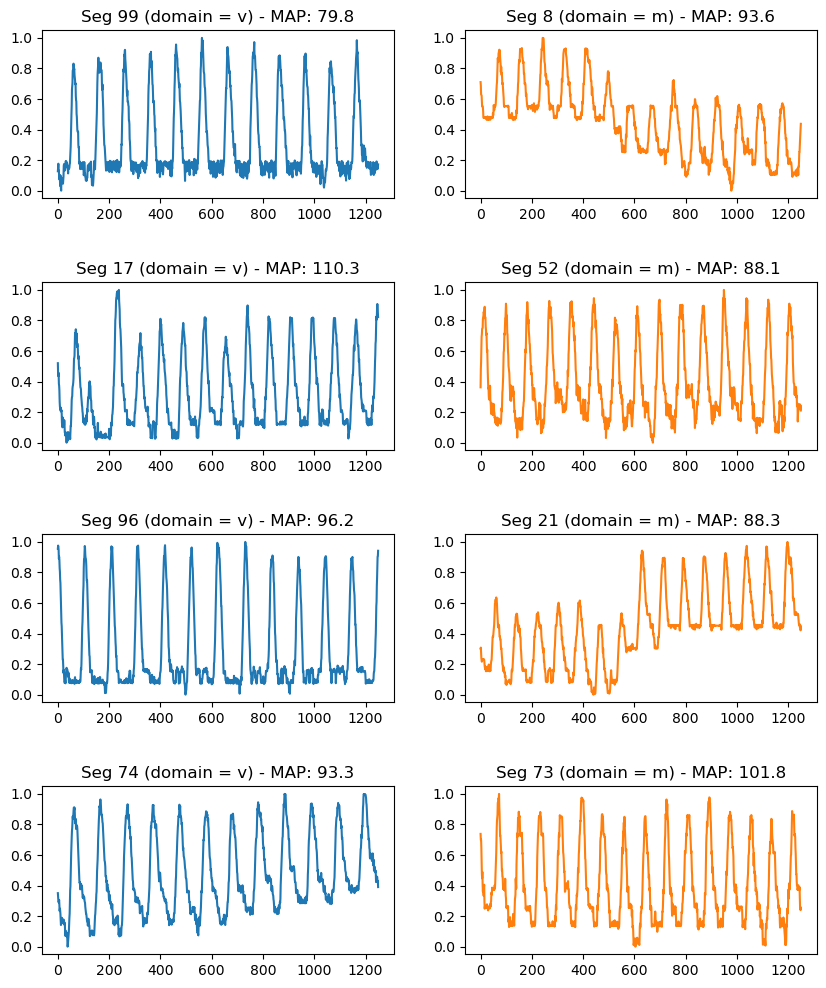

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.random.choice(min(100, len(X_m), len(X_v)), size=8, replace=False)
for i, ax in enumerate(axes.ravel()):
    d = "v" if i % 2 == 0 else "m"
    X_, y_ = (X_v, y) if i % 2 == 0 else (X_m, y_m)

    ax.plot(X_.iloc[idx[i]]["ppg"], c=f"C{i % 2}")
    ax.set_title(f"Seg {idx[i]} (domain = {d}) - MAP: {y_[idx[i]]:.1f}")

# Challenge evaluation

For this challenge, the metric used to evaluate the performance of the model is the mean absolute error (MAE) between the predicted MAP and the true MAP, defined as:

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{pred}^i - y_{true}^i|
$$

Here, we take the MAE over the test set, which is composed of signals coming
from domain `m`.

### A first model without the waveforms

We can start by building a simple model without the waveforms to see how well we can predict the MAP from the demographic information and the low-frequency signals.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge


from sklearn import set_config

set_config(transform_output="pandas")

from sklearn.metrics import mean_absolute_error


X_df, y = problem.get_train_data(load_waveform=False)
X_df_test, y_test = problem.get_test_data(load_waveform=False)


class IgnoreAdapter(RandomForestRegressor):
    def fit(self, X, y):
        X = X[~y.isna()]
        y = y[~y.isna()]
        return super().fit(X, y)

    def predict(self, X):
        return super().predict(X.drop(columns=["domain"]))


clf = make_pipeline(
    make_column_transformer(
        ("passthrough", ["age"]),
        (
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            ),
            ["gender"],
        ),
    ),
    RandomForestRegressor(n_estimators=50),
    # Ridge(alpha=1)
)
clf.fit(X_df, y)
print(f"Score on train: {mean_absolute_error(clf.predict(X_df), y)}")
print(f"Score on test: {mean_absolute_error(clf.predict(X_df_test), y_test)}")

Score on train: 4.271797320928468
Score on test: 6.518893594473021


# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the RAMP plateform.

This section also show how to use the `ramp-workflow` library to test the submission locally.

## The pipeline workflow

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [11]:
# %load submissions/starting_kit/estimator.py

from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

set_config(transform_output="pandas")


class IgnoreDomain(RandomForestRegressor):
    def fit(self, X, y):
        # Ignore the samples with missing target
        X = X[y != -1]
        y = y[y != -1]
        return super().fit(X, y)


def get_estimator():
    return make_pipeline(
        make_column_transformer(
            ("passthrough", ["age"]),
            (
                OrdinalEncoder(
                    handle_unknown="use_encoded_value", unknown_value=-1
                ),
                ["gender"],
            ),
        ),
        IgnoreDomain(n_estimators=50),
    )


## Testing using a scikit-learn pipeline

In [12]:
import problem
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data()

scores = cross_val_score(
    get_estimator(), X_df, y, cv=5, scoring="neg_mean_absolute_error"
)
print(scores)

[-11.57226293 -16.73182548 -63.2044449  -88.05626467 -70.38334216]


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).